<a href="https://colab.research.google.com/github/RealYarik/ard/blob/main/1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithms for Big Data - Exercise 4
This lecture is focused in more detailed understanding of the Convolution neural networks. 

The visualization and the response of the CNN layers will be intestigated and a proper.

We will use the MNIST dataset but other may be used as well.


[Open in Google colab](https://colab.research.google.com/gist/RealYarik/085d4e375e19589a27c129f032352324/-ds4_04-ipynb.ipynb)

In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.preprocessing import normalize # normalization of the matrix
from scipy.signal import convolve2d # convolutionof the 2D signals
import scipy

tf.version.VERSION

'2.3.0'

In [11]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

def show_example(train_x, train_y, class_names):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i].reshape(28,28), cmap=plt.cm.binary)
        plt.xlabel(class_names[train_y[i]])
    plt.show()

In [12]:
class Mish(keras.layers.Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

keras.utils.get_custom_objects().update({'mish': Mish(mish)})

In [13]:
# mnist is the basic dataset for image classifaction
dataset = tf.keras.datasets.mnist

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

train_x = train_x.reshape(*train_x.shape, 1)
test_x = test_x.reshape(*test_x.shape, 1)

train_x = train_x/255.0
test_x = test_x/255.0

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# the data are in the form of 32x32 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names = [str(x) for x in range(10)]
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_count = len(class_names)
print('Class count:', class_count, class_names)


Train data shape:  (48000, 28, 28, 1) (48000,)
Validation data shape:  (12000, 28, 28, 1) (12000,)
Test data shape:   (10000, 28, 28, 1) (10000,)
Class count: 10 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Denoising-autoencoder
The denoising autoencoder is a autoencoder that will learn how to remove random noise from the images. 

First, noisy images have to be generated. 

Then the autoencoder need to be created and trained. 

Then denosed images may be reconstructed.

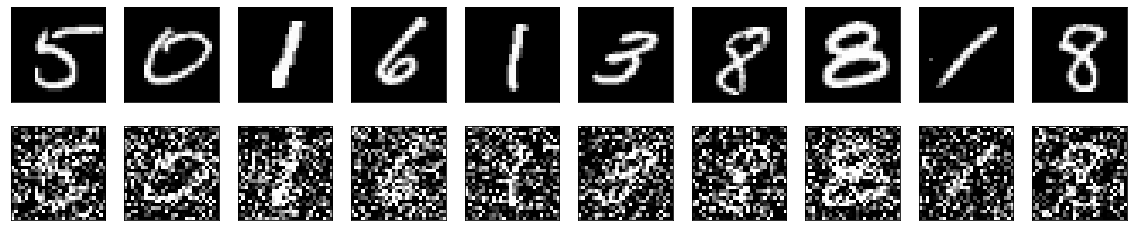

In [14]:
noise_factor = 0.65
noisy_train_x = np.clip(train_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_x.shape), 0., 1.)
noisy_valid_x = np.clip(valid_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_x.shape), 0., 1.)
noisy_test_x = np.clip(test_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_x.shape), 0., 1.) 


n = 10
plt.figure(figsize=(2*n, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(train_x[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, n+i+1)
    plt.imshow(noisy_train_x[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Autoencoder**

In [71]:
autoencoder = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),    
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    # a 128 values of the minimized knowledge / features
    keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    keras.layers.UpSampling2D((2,2)),
    keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    keras.layers.UpSampling2D((2,2)),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.UpSampling2D((2,2)),
    
    keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')
])

**Fit the model**

Epoch 1/20
375/375 [==============================] - 4s 10ms/step - loss: 0.1164 - accuracy: 0.8107 - val_loss: 0.1168 - val_accuracy: 0.8112
Epoch 2/20
375/375 [==============================] - 3s 9ms/step - loss: 0.1150 - accuracy: 0.8109 - val_loss: 0.1159 - val_accuracy: 0.8113
Epoch 3/20
375/375 [==============================] - 3s 9ms/step - loss: 0.1142 - accuracy: 0.8110 - val_loss: 0.1157 - val_accuracy: 0.8116
Epoch 4/20
375/375 [==============================] - 3s 9ms/step - loss: 0.1135 - accuracy: 0.8111 - val_loss: 0.1152 - val_accuracy: 0.8119
Epoch 5/20
375/375 [==============================] - 3s 9ms/step - loss: 0.1129 - accuracy: 0.8112 - val_loss: 0.1144 - val_accuracy: 0.8110
Epoch 6/20
375/375 [==============================] - 3s 9ms/step - loss: 0.1124 - accuracy: 0.8113 - val_loss: 0.1140 - val_accuracy: 0.8117
Epoch 7/20
375/375 [==============================] - 3s 9ms/step - loss: 0.1120 - accuracy: 0.8113 - val_loss: 0.1134 - val_accuracy: 0.8112
Epoch

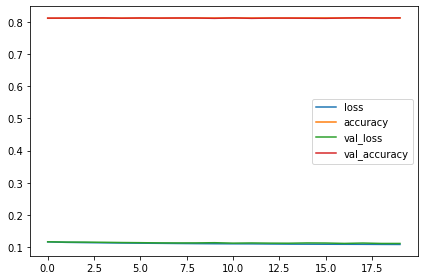

In [73]:
autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = autoencoder.fit(noisy_train_x, train_x, validation_data=(noisy_valid_x, valid_x), epochs=20, batch_size=128)
show_history(history)


**Result**

Result:


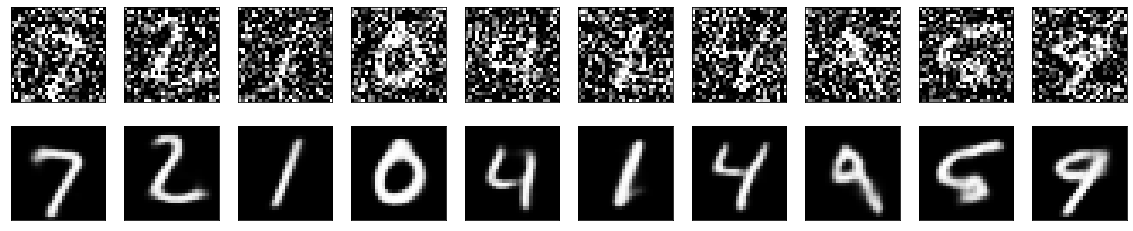

In [74]:
decoded_imgs = autoencoder.predict(noisy_test_x)
n = 10
plt.figure(figsize=(2*n, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(noisy_test_x[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, n+i+1)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
print("Result:")    
plt.show()
